# Lab 02: Deep Neural Networks in PyTorch

In [1]:
try:
  from google.colab import drive
  IN_COLAB=True
except:
  IN_COLAB=False

if IN_COLAB:
  print("We're running Colab")

if IN_COLAB:
  # Mount the Google Drive at mount
  mount='/content/drive'
  print("Colab: mounting Google drive on ", mount)

  drive.mount(mount)

  # Switch to the directory on the Google Drive that you want to use
  import os
  drive_root = mount + "/My Drive/Colab Notebooks/GAN_Course"
  
  # Create drive_root if it doesn't exist
  create_drive_root = True
  if create_drive_root:
    print("\nColab: making sure ", drive_root, " exists.")
    os.makedirs(drive_root, exist_ok=True)
  
  # Change to the directory
  print("\nColab: Changing directory to ", drive_root)
  %cd $drive_root
  !pwd

Author Henrik Horst, opencampus.sh

10.11.2022

At its core, PyTorch is a library for
- doing math on arrays
- with automatic calculation of gradients
- that is easy to accelerate with GPUs and distribute over nodes.

Much of the time,
we work at a remove from the core features of PyTorch,
using abstractions from `torch.nn`
or from frameworks on top of PyTorch.

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import pandas as pd

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Okay, so what next?

How do we run these neural networks on the GPU?

## Training on GPU
Just like how you transfer a Tensor onto the GPU, you transfer the neural
net onto the GPU.

Let's first define our device as the first visible cuda device if we have
CUDA available:



In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# what this nice little function does that it checks at the beginning which device we have availble and then we can send in our cells below just
# everything to device and do not have to manually code it always which is the currently running device.

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


If you are not running on a GPU instance change it in the top menu with: Runtime -> Change runtime type -> GPU

In [4]:
random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [5]:
'''Here we load our CIFAR Dataset again but we added the transform argument with is that during loading the MNIST PIL Images
 are directly converted to PyTorch Tensors and normalized with their dataset specific values. We could compute these on our own but other people have
 already done this so there is no use to do it here on our own.'''
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 16
#load CIFAR10 Training dataset into a PyTorch Dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
#wrap train_dataset into a load for automatic batch generation and shuffling
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


In [6]:
#Let's get some examples
examples = enumerate(trainloader)
batch_idx, (example_data, example_targets) = next(examples)
batch_idx1, (example_data, example_targets) = next(examples)

In [7]:
batch_idx, batch_idx1

(0, 1)

In [8]:
example_data.shape, example_targets.shape,  # Batch size, channels, width, height / labels

(torch.Size([16, 3, 32, 32]), torch.Size([16]))

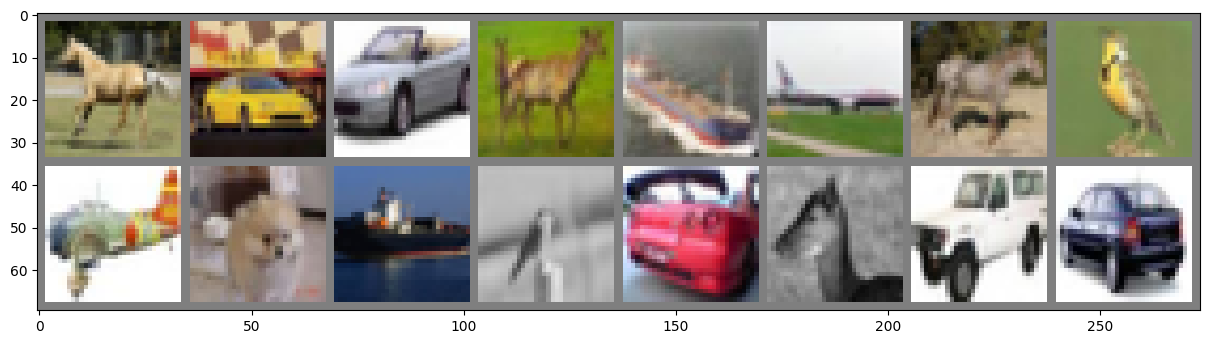

horse car   car   deer  ship  plane horse bird  plane dog   ship  bird  car   deer  car   car  


In [9]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(15,5))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))


## Let's build our Neural Network

This time it is a CNN

In [10]:
import torch.nn as nn
import torch.nn.functional as F

class CIFAR10Classifier(nn.Module):
  def __init__(self):
    super().__init__()

    # counter and accumulator for progress
    self.counter = 0
    self.progress = []

    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

    # loss
    self.loss_function = nn.CrossEntropyLoss()

    # optimizer
    self.optimiser = torch.optim.Adam(self.parameters(), lr=0.01)

  def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

  def train(self, inputs, targets):
              
        outputs = self(inputs)
        
        # calculate loss
        loss = self.loss_function(outputs, targets)

        # increase counter and accumulate error every 10
        self.counter += 1
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass
        if (self.counter % 1000 == 0):
            print("counter = ", self.counter)
            pass

        # zero gradients, perform a backward pass, and update the weights
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()
    
  def plot_progress(self):
        df = pd.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0, 1.0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))



In [11]:
%%time 
# create neural network

C = CIFAR10Classifier().to(device)

# train network on MNIST data set

epochs = 4

for i in range(epochs):
    print('training epoch', i+1, "of", epochs)
    for image_data_tensor, target_tensor in trainloader:
        C.train(image_data_tensor.to(device), target_tensor.to(device))
        
  

training epoch 1 of 4
counter =  1000
counter =  2000
counter =  3000
training epoch 2 of 4
counter =  4000
counter =  5000
counter =  6000
training epoch 3 of 4
counter =  7000
counter =  8000
counter =  9000
training epoch 4 of 4
counter =  10000
counter =  11000
counter =  12000
CPU times: user 1min 45s, sys: 36.9 s, total: 2min 22s
Wall time: 2min 32s


In [12]:
PATH = './cifar_net.pth'
torch.save(C.state_dict(), PATH)

In [13]:
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified


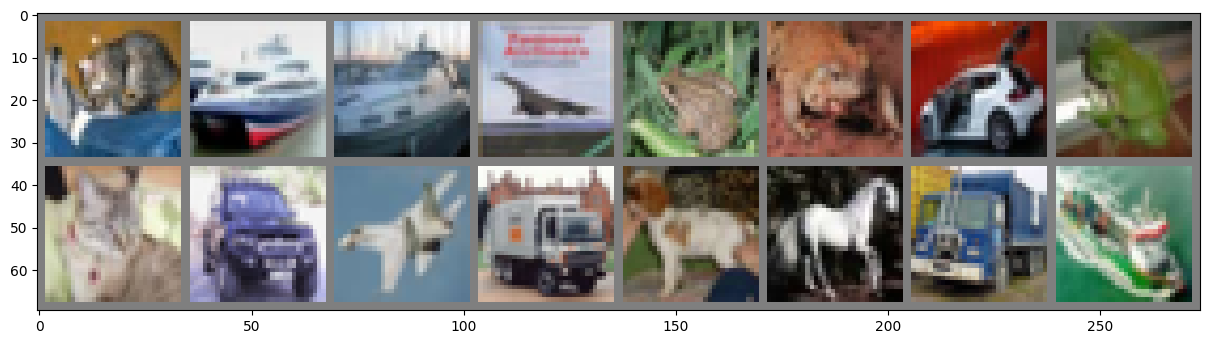

GroundTruth:  cat   ship  ship  plane frog  frog  car   frog  cat   car   plane truck dog   horse truck ship 


In [14]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

###Load our Model from saved file

In [15]:
loadedC = CIFAR10Classifier().to(device)
loadedC.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [16]:
#generate some predictions
outputs = loadedC(images.to(device))

In [17]:
_, predicted = torch.max(outputs, 1)

print('Predicted:   ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(batch_size)))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

Predicted:    dog   car   truck ship  frog  frog  truck frog  frog  car   plane car   horse truck truck horse
GroundTruth:  cat   ship  ship  plane frog  frog  car   frog  cat   car   plane truck dog   horse truck ship 


In [18]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
      images, labels = data
      # calculate outputs by running images through the network
      outputs = loadedC(images.to(device))
      # the class with the highest energy is what we choose as prediction
      _, predicted = torch.max(outputs.data, 1)
      total += labels.to(device).size(0)
      correct += (predicted == labels.to(device)).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 30 %


In [20]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = loadedC(images.to(device))
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels.to(device), predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 51.1 %
Accuracy for class: car   is 50.2 %
Accuracy for class: bird  is 3.5 %
Accuracy for class: cat   is 0.7 %
Accuracy for class: deer  is 0.0 %
Accuracy for class: dog   is 36.6 %
Accuracy for class: frog  is 63.4 %
Accuracy for class: horse is 37.9 %
Accuracy for class: ship  is 21.8 %
Accuracy for class: truck is 43.0 %


As you see it becomes annoying to always add .to(device). In the future we will go on th PyTorch Lightning which will handle this automatically and provides also another set of really nice features